In [9]:
# Code setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp
import sys

sys.path.insert(0,'src')

In [2]:
from data_funcs import plot_data

## Data

### Fuel Moisture Background

[Fuel moisture content](https://www.ncei.noaa.gov/access/monitoring/dyk/deadfuelmoisture) (FM) is a critical component of wildfire susceptibility and fire spread. It is a measure of the water content in vegetation. Dry fuels burn more readily, and wetter fuels burn more slowly or not at all. Atmospheric conditions affect FM in a variety of ways. Temperature is a key component of FM; warmer temperatures dry out fuels, with other factors being held constant. Relative humidity (RH) is another key component of FM; more moisture in the air generally leads to more moisture in fuels. Higher wind speeds lead to drier fuels. Finally, solar radiation dries out fuels. Cloudy days with little direct solar radiation will generally lead to higher FM conditions. It is important to note that these atmospheric conditions relate to each other in complicated ways. For example, higher temperatures can cause lower RH and are also associated with stronger solar radiation, all of which lead to lower FM. However, higher temperatures can cause more evaporation and lead to increases in precipitation, which in turn increases FM. There are many other local conditions that affect fuel moisture, many of which are difficult to resolve in a modeling context. For example, wind speed interacts with the slope angle of the terrain. Wind that blows upslope tends to make more contact with fuels and thus dry fuels out faster. Many of these local conditions will not be included in modeling in this project. 

![](https://www.wfas.net/images/firedanger/fm_10.png)

The table below summarizes the atmospheric variables used in this project to model FM. All these variables are defined at the surface level, they have various other units and definitions at higher altitudes.

| Name              | Units  |
|-------------------|--------|
| Air Temperature   | K    | 
| Relative Humidity | %    |
| Precipitation     | mm/h |
| Wind Speed        | m/s  |
| Solar Radiation   | kWh/m2 |

Researchers often choose to model dead fuel moisture, or the water content of dead vegetation. This is due to several factors. Living plants try to maintain homeostasis, so they resist large fluctuations in moisture caused by atmospheric conditions. The water content of dead fuel, on the other hand, responds readily to atmospheric conditions and therefore there can be large fluctuations that are relevant to wildfire spread. Additionally, live fuels are thought of as composites of various fuel types. A sagebrush, for example, has woody material of various diameters as well as herbaceous material. These various materials retain moisture in different ways and respond to fire differently. 

Dead fuel moisture is divided into different classes based on how quickly the material responds to changes in atmospheric conditions. These include 1-hour, 10-hour, 100-hour, and 1,000-hour fuels. This category is defined as the time it would take for 2/3 of the fuel to change FM in response to changing atmospheric conditions. A 1-hour fuel, very small twigs for example, will get wetter quickly when exposed to rain, while a 1,000-hour fuel like a fallen log would take much longer to absorb rain and adjust its FM. In this project, we will work only with dead 10-hour fuels.

![](images/fm_types.png)

Source: NOAA https://www.ncei.noaa.gov/access/monitoring/dyk/deadfuelmoisture#:~:text=Fuel%20moisture%20is%20a%20measure,content%20would%20be%20zero%20percent.

The National Oceanic and Atmospheric Administration (NOAA) operates Remote Automatic Weather Stations (RAWS) across the country to measure hourly FM and other associated environmental variables. The map below shows the locations of the RAWS stations that also have complete sensors to observe the atmospheric variables listed above.

![](images/raws_stations.png)

### Predictors of Fuel Moisture

Fuel moisture is highly correlated in time, as wet wood takes time to dry out in dry conditions, and time to absorb water in wet ones. The plot below shows 1 week of FM observations. The x-axis is arranged in 24-hour periods. Notice the clear cyclical pattern throughout a day where the highs and lows of FM occur with 24-hour periods. There was zero rainfall at this station over this week, so the patterns of FM are relatively smooth.

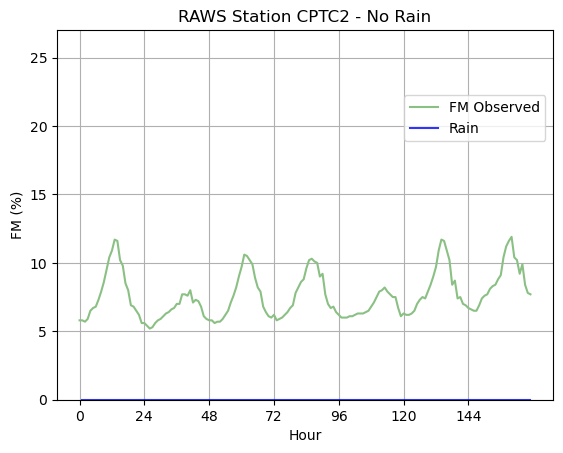

In [3]:
dat = pd.read_pickle('data/raws_dat.pickle') # all RAWS observations

dat = dat['CPTC2'] # restrict to one station for visualization

hours = 24*30 # one month of data

plt.plot(dat['fm'][0:24*7], linestyle='-',c='#8BC084',label='FM Observed')
plt.plot(dat['rain'][0:24*7], c='b',label='Rain', alpha=.8)
plt.legend()
plt.ylabel("FM (%)")
plt.xlabel("Hour")
plt.ylim(0, 27)
plt.xticks(range(0, 24*7, 24))
plt.legend(loc=(.7, .7))
plt.title("RAWS Station CPTC2 - No Rain")
plt.grid()

In another time period at the same location, there are several rainfall instances. The rain comes in short bursts and there are associated spikes in the FM.

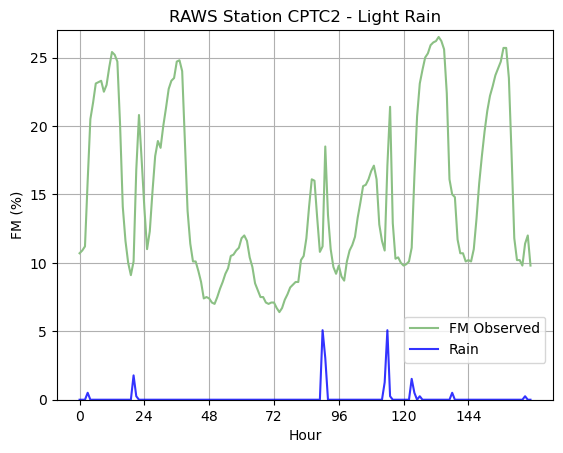

In [4]:
plt.plot(dat['fm'][24*14:24*21], linestyle='-',c='#8BC084',label='FM Observed')
plt.plot(dat['rain'][24*14:24*21], c='b',label='Rain', alpha=.8)
plt.legend()
plt.ylabel("FM (%)")
plt.xlabel("Hour")
plt.xticks(range(0, 24*7, 24))
plt.ylim(0, 27)
plt.legend(loc=(.7, .1))
plt.title("RAWS Station CPTC2 - Light Rain")
plt.grid()

Temperature and RH both affect fuel moisture, but they also strongly affect each other. The plot below shows a month of data at the same RAWS station location. The relationships between temperature and RH with fuel moisture are not at all apparent in this formulation.

Text(0.5, 0, 'Temp (deg K)')

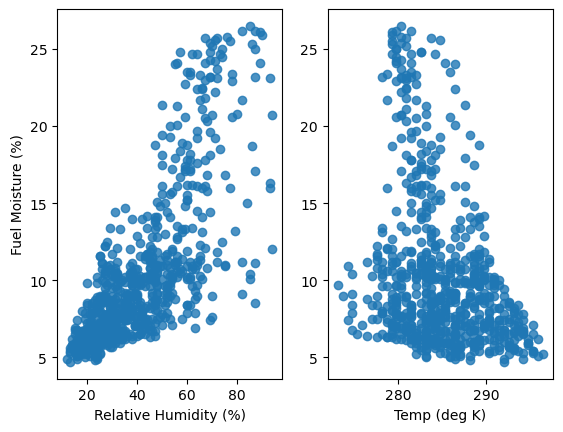

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(dat['rh'][0:hours], dat['fm'][0:hours], alpha=.8)
ax1.set_ylabel("Fuel Moisture (%)")
ax1.set_xlabel("Relative Humidity (%)")
ax2.scatter(dat['temp'][0:hours], dat['fm'][0:hours], alpha=.8)
ax2.set_xlabel("Temp (deg K)")

Researchers have developed the concept of Equilibrium Moisture Content to better understand the relationship between FM, RH, and temperature. [Equilibrium Moisture Content](https://nhess.copernicus.org/articles/14/2829/2014/nhess-14-2829-2014.pdf) is the theoretical FM if a fuel was left exposed to the same atmospheric conditions for a long time. The plots below show the relationship with Equilibrium Moisture for the same time period as the plot above. The relationship is much clearer here. Generally, as RH increases, FM increases. Additionally, as temperature increases, FM decreases.

Text(0.5, 0, 'Temp (deg K)')

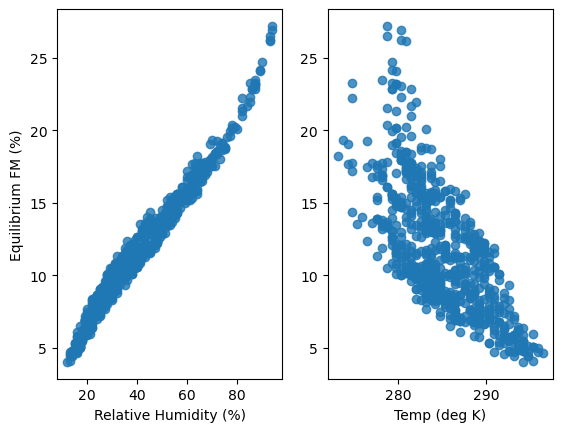

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(dat['rh'][0:hours], dat['Ew'][0:hours], alpha=.8)
ax1.set_ylabel("Equilibrium FM (%)")
ax1.set_xlabel("Relative Humidity (%)")
ax2.scatter(dat['temp'][0:hours], dat['Ew'][0:hours], alpha=.8)
ax2.set_xlabel("Temp (deg K)")

In the plot below, we see how the FM observation lags behind the equilibrium values. At at point of time, if the equilibria values remained constant, the fuels would approach the value exponentially over time. But the equilibria are constantly moving, so we see the pattern below where the peaks in FM are slightly in the future compared to the peaks in the equilibria.

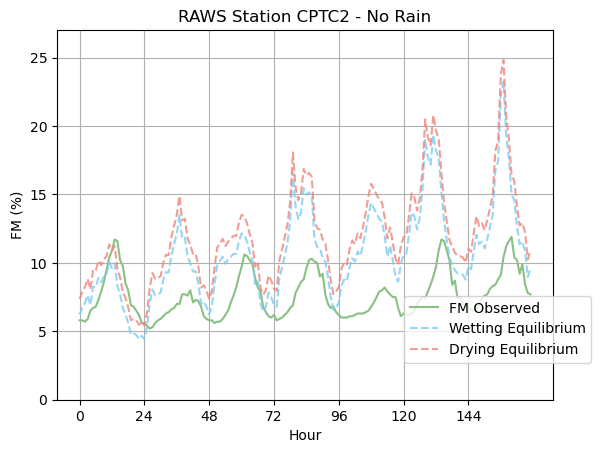

In [7]:
plt.plot(dat['fm'][0:24*7], linestyle='-',c='#8BC084',label='FM Observed')
plt.plot(dat['Ew'][0:24*7],label='Wetting Equilibrium', linestyle='--',c='#7CCCEF', alpha=.8)
plt.plot(dat['Ed'][0:24*7],label='Drying Equilibrium', linestyle='--',c='#EF847C', alpha=.8)
plt.legend()
plt.ylabel("FM (%)")
plt.xlabel("Hour")
plt.ylim(0, 27)
plt.xticks(range(0, 24*7, 24))
plt.legend(loc=(.7, .1))
plt.title("RAWS Station CPTC2 - No Rain")
plt.grid()

When rain is present, the pattern is more complicated. In the plot below we see the observed fuel moisture is larger than the equilibria values.

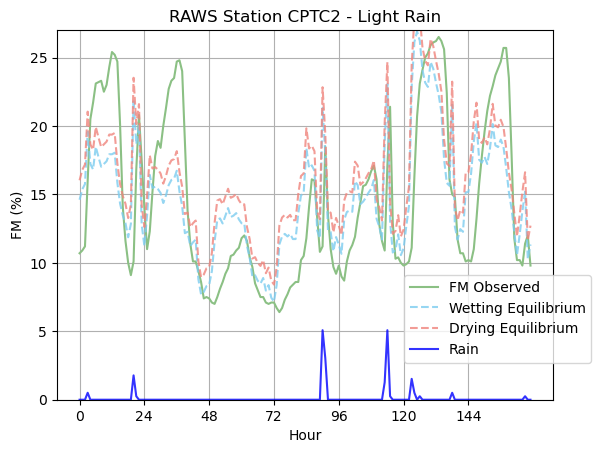

In [8]:
plt.plot(dat['fm'][24*14:24*21], linestyle='-',c='#8BC084',label='FM Observed')
plt.plot(dat['Ew'][24*14:24*21],label='Wetting Equilibrium', linestyle='--',c='#7CCCEF', alpha=.8)
plt.plot(dat['Ed'][24*14:24*21], label='Drying Equilibrium', linestyle='--',c='#EF847C', alpha=.8)
plt.plot(dat['rain'][24*14:24*21], c='b',label='Rain', alpha=.8)
plt.legend()
plt.ylabel("FM (%)")
plt.xlabel("Hour")
plt.xticks(range(0, 24*7, 24))
plt.ylim(0, 27)
plt.legend(loc=(.7, .1))
plt.title("RAWS Station CPTC2 - Light Rain")
plt.grid()

### Fuel Moisture Nonlinear Effect on Rate of Spread

[Rate of spread](https://www.nwcg.gov/course/ffm/fire-behavior/83-rate-of-spread#:~:text=The%20rate%20of%20spread%20is,origin%20quickly%20with%20great%20intensity.) (ROS) is a measure of the speed a fire moves from a point of origin. The following image shows the nonlinear relationship between FM and ROS at a single spatial location, while holding other variables associated with ROS constant. Wildfire spreads most readily in dry fuels, as seen in the peak of the ROS curve at zero FM. The ROS drops off quickly as fuels get wetter, but then it levels off until the ROS is zero, or when the FM reaches the [moisture of extinction](https://www.nwcg.gov/publications/pms437/fuels/surface-fuel-model-selection#TOC-Moisture-of-Extinction). This pattern motivates the research goal of this project: to train fuel moisture models to be more accurate for dry fuels. Models that are accurate in in the critical range of fuel moisture values may be preferrable to models that have a lower overall accuracy.

![](https://wiki.openwfm.org/mediawiki/images/9/9b/Grass-fmc.png)


If the goal of training fuel moisture models is to get more accurate forecasts of wildfire ROS, it is intuitive that models should be trained directly on ROS. Instead of using loss functions on FM, why not construct a loss function directly with ROS? First, wildfire ROS is a complicated multifaceted concept, and fuel moisture is one of many components. It is computationally impractical to model everything at once. A more realistic option would be to weight errors in fuel moisture models more heavily for dry fuel. Mathematically, there are two important issues with training models directly on ROS:

1. Fuel moisture is highly correlated in time.
2. Rate of spread reaches the extinction value relatively quickly for dead fuels.

Since fuel moisture content is the "percent of the dry weight of that specific fuel" ([from NOAA](https://www.ncei.noaa.gov/access/monitoring/dyk/deadfuelmoisture#:~:text=Fuel%20moisture%20is%20a%20measure,content%20would%20be%20zero%20percent.)), this value can easily go over 100% for very wet fuels, since the water content can weight more than the underlying burnable material. The extinction value for tall grass, depicted above, reaches its extinction moisture value at roughly 25%. Thus, the ROS for tall grass with 25% FM would be the same as that of tall grass with 150% FM. In both cases, the ROS would be zero. 

This fact, combined with the temporal correlation of FM, makes it potentially undesirable to train FM models directly on ROS. Consider a case when the true FM content was 30% for tall grass. Model 1 predicts 25% FM and Model 2 predicts 150%. Both models would receive a loss of zero for that prediction, since both models predict zero ROS which matches the observed value. However, if atmospheric conditions led to the fuel drying out over time, the models would predict very different ROS within a few hours. Fuels with an FM of 25% would dry out relatively quickly compared to fuels with an FM of 150%, and thus the ROS would be nonzero in the former case much sooner than the latter if exposed to dry conditions. 

## Fuel Moisture Modeling - A Brief Literature Review

*Note: I haven't finished this yet. When I last met with Jan, he wanted me to include much more history of the physics-based methods.*

## Methods

### Custom Loss Functions

We wish to develop loss functions that are more accurate for dry fuels, but do not overfit the data and loss predictive accuracy. There are two potential loss functions that will be considered the "baseline" cases:

1. Train fuel moisture models using the residual sum of squares (RSS) of the errors, without weighting on the fuel moisture level. The mathematical form of this loss function would be:

* $N$: number of observations.
* $y_i$: $i^{th}$ observed FM value.
* $\hat y_i$: $i^{th}$ fitted FM value.

$$RSS_1 = \sum_{t=1}^N\frac{1}{N}(y_t - \hat y_t)^2$$

Note that the weight of $\frac{1}{N}$ is not typically included, since it is not needed because $\sum_{i=1}^N\frac{1}{N}=1$. It is included here for clarity.

2. Assign weights based on the values of the rate of spread.

* $w_i$: weight assigned to error of predicting the $i^{th}$ fm value
* $ros(y_i)$: the theoretical rate of spread associated with the $i^{th}$ fuel moisture value.

$$RSS_2 = \sum_{i=t}^N w_i(y_t - \hat y_t)^2$$
$$w_i = \frac{ros(y_t)}{\sum_{i=1}^N ros(y_t)}$$

The sum in the denominator of the weight formula above is to guarentee the weights sum to one, or $\sum_{i=1}^N w_i=1$. (This is not strictly necessary for many models, including ordinary linear regression.)

Note that approach 2 is not identical to training models directly on rate of spread as the response. For example, an observed fuel of 100%, well past the extinction moisture value for any fuel, would receive a weight of 0 in approach 2. That means that the training procedure would totally ignore errors associated with that observed value. By contrast, if rate of spread was the response variable, the observed 100% would be translated into a 0 rate of spread value, but it would still get equal weight $(1/N)$ in the training procedure.

The baseline loss functions could be seen as two extremes. We hypothesize that neither approach would be optimal. Another loss function would be:

3. Compromise between the two baseline cases using a weighted average of the weights. This could be expressed mathematically as:

* $\alpha$: hyperparameter that defines the weighted average between the two baseline case weighting schemes.

$$RSS_3 = \sum_{i=1}^N w_i'(y_t - \hat y_t)^2$$
$$w_t'=\alpha\left(\frac{1}{N}\right)+(1-\alpha)\frac{ros(y_t)}{\sum_{t=1}^N ros(y_t)}, \text{ for }\alpha\in(0,1)$$



In this formulation of the loss function, values of $\alpha$ close to 1 would correspond to ordinary least squares with fuel moisture as the response (baseline case 1) and values close to 0 would correspond to a weighted least squares scenario where the weights are directly related to the rate of spread value (baseline case 2).

## References

* Open Wildland Fire Modeling E Community. https://wiki.openwfm.org/wiki/
* National Wildfire Coordinating Group (NWCG). https://www.nwcg.gov/course/ffm/
* *Dead Fuel Moisture*, NOAA National Centers for Environmental Information. https://www.ncei.noaa.gov/access/monitoring/dyk/deadfuelmoisture
* *Recent advances and applications of WRF–S. National Wildfire Coordinating GroupFIRE*. Mandel (2014). https://nhess.copernicus.org/articles/14/2829/2014/nhess-14-2829-2014.pdf* *Surface Fuel Model Selection*. National Wildfire Coordinating Group, (2023). https://www.nwcg.gov/publications/pms437/fuels/surface-fuel-model-selection#TOC-Moisture-of-Extinction